In [1]:
import glworia.load_interp
from glworia.load_interp import *
import bilby_scripts.waveform
from bilby_scripts.waveform import *
import bilby

In [2]:
import configparser
import matplotlib.pyplot as plt

In [3]:
from importlib import reload

In [4]:
reload(glworia.load_interp)
from glworia.load_interp import *
reload(bilby_scripts.waveform)
from bilby_scripts.waveform import *

In [5]:
import matplotlib.pyplot as plt

In [13]:
lp_name = 'x_c'

settings = {
    'lens_param_name': lp_name,
    'y_low': 0.1,
    'y_high': 5.0,
    lp_name + '_low': 0.,
    lp_name + '_high': 1.,
    'N_grid': 31,
    'N_grid_strong': 61,
    'N_crit': 61,
    'N': 200,
    'lens_model_name': 'CIS',

    'T0_max': 1000,

    'y_low_im': 0.1,
    'y_high_im': 5.0,
    lp_name + '_low_im': 0.,
    lp_name + '_high_im': 1.,
    'N_grid_im': 201,
    'N_crit_im': 201,

    'mask_crit_fac': 0.2,
    'crit_param_low': 0.1,
    'crit_param_high': 10.
}

In [14]:
interpolators = load_interpolators('./interpolation', **settings)

In [15]:
# def strong_lens_cond_override_gSIS(strongly_lensed, y_interp, kappa_interp):
#     if np.abs(kappa_interp - 1.) < 1e-15:
#         if y_interp < 1.:
#             strongly_lensed = True
#         else:
#             strongly_lensed = False
#     return strongly_lensed

In [16]:
w_interp = np.linspace(0.001, 1e4, 10**6)

In [45]:
y_interp = 2.0
lp_interp = 1.0

In [46]:
F, F_g, partitions, T_im, mu_im, u0, u1, u2, u3, um, w1, F1, w2, F2 = F_interp(w_interp, y_interp, lp_interp, interpolators, settings,
             return_geom = True, 
             )

/home/mcheung1/Lensing/Glworia_jax/glworia_jax/glworia/load_interp.py:222: RuntimeWarning: divide by zero encountered in divide
  return (1 + np.tanh((x - x0)/a))/2


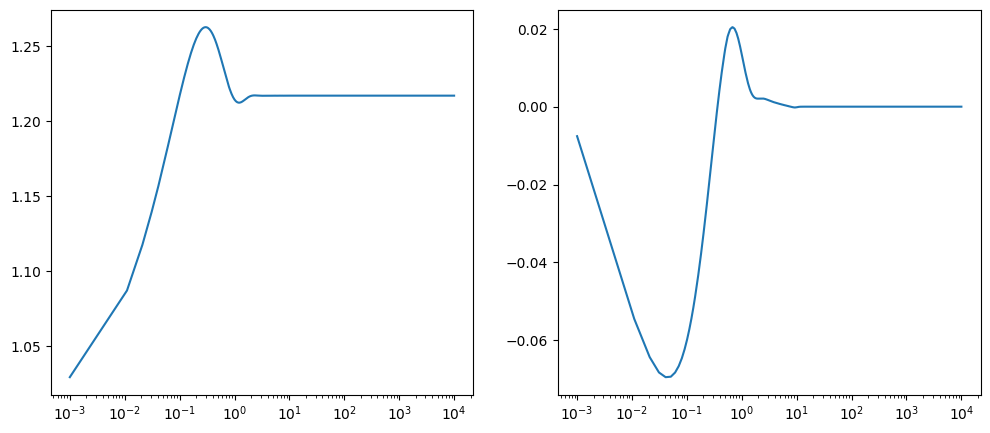

In [47]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))
axs[0].semilogx(w_interp, np.abs(F))
# axs[0].semilogx(w_interp, np.abs(F_g), alpha = 0.5)
axs[1].semilogx(w_interp, np.angle(F))

In [48]:
duration = 4.0
sampling_frequency = 1024.0


waveform_arguments = dict(
    waveform_approximant="IMRPhenomXPHM",
    reference_frequency=50.0,
    minimum_frequency=20.0,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
# the generator will convert all the parameters
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)


11:53 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [49]:
wf_param_dict = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    luminosity_distance=500,
    ra=1.375,
    dec=-1.2108,
)

In [50]:
strain_dict = waveform_generator.frequency_domain_strain(wf_param_dict)

In [60]:
freq = waveform_generator.frequency_array
Mtow = 8*np.pi*G/c**3*Msun
MLz = 100
freq_w = w_interp/MLz/Mtow

In [59]:
ifos[0]

NameError: name 'ifos' is not defined

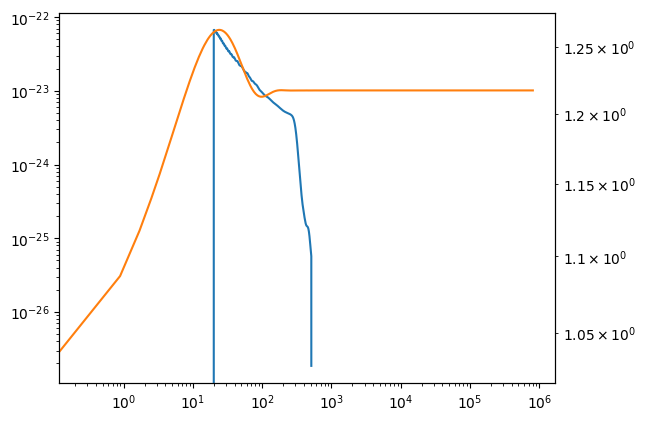

In [61]:
fig, ax = plt.subplots()
ax.loglog(freq, np.abs(strain_dict['plus']))
ax2 = ax.twinx()
ax2.loglog(freq_w, np.abs(F), color = 'C1')

In [ ]:
waveform_generator.

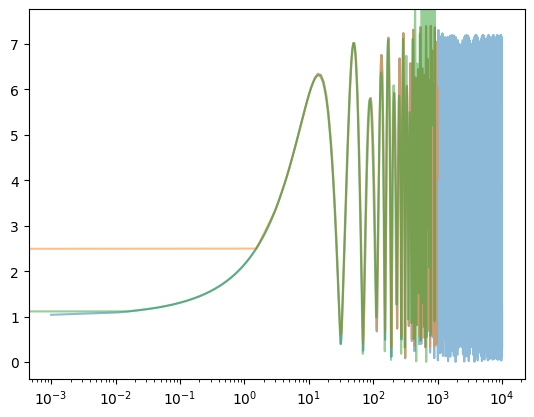

In [79]:
# cut at 1e3

F1_cut = F1[w1 < 1e3]
w1_cut = w1[w1 < 1e3]
F2_cut = F2[w2 < 1e3]
w2_cut = w2[w2 < 1e3]

plt.semilogx(w_interp, np.abs(F), alpha = 0.5)
plt.xlim(*plt.xlim())
plt.ylim(*plt.ylim())

plt.semilogx(w1_cut, np.abs(F1_cut), alpha = 0.5)
plt.semilogx(w2_cut, np.abs(F2_cut), alpha = 0.5)

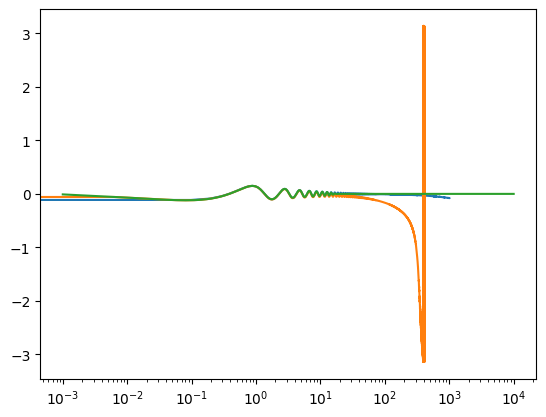

In [87]:
plt.semilogx(w1_cut, np.angle(F1_cut))
plt.semilogx(w2_cut, np.angle(F2_cut))
plt.semilogx(w_interp, np.angle(F))

# plt.ylim(1, 2)

In [54]:
F_scale = np.max(np.abs(F-1))/2

(0.001, 10.0)

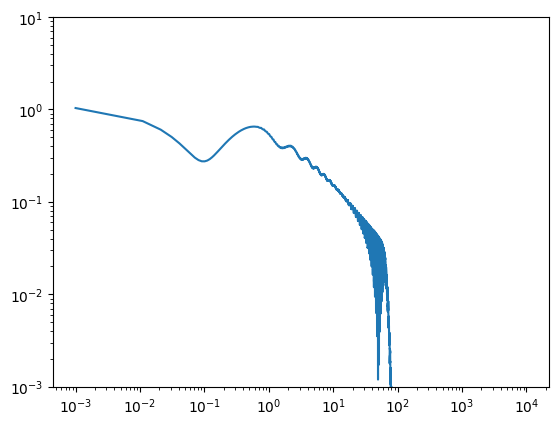

In [55]:
fig, ax = plt.subplots()
ax.loglog(w_interp, np.abs((F-F_g)/F_scale))
ax.set_ylim(1e-3, 1e1)